In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import butter, filtfilt, hilbert, convolve
import mne

raw = mne.io.read_raw_edf('/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/sub-01_ses-01_task-verbalWM_run-01_ieeg.edf', preload=True)
print(raw.info)

Extracting EDF parameters from /Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/sub-01_ses-01_task-verbalWM_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 799999  =      0.000 ...   400.000 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: mAHL1, mAHL2, mAHL3, mAHL4, mAHL5, mAHL6, mAHL7, mAHL8, mAL1, ...
 chs: 48 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2023-09-13 10:27:08 UTC
 nchan: 48
 projs: []
 sfreq: 2000.0 Hz
 subject_info: <subject_info | his_id: <no>
>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import butter, filtfilt, hilbert, convolve
import mne
from mne.filter import filter_data
mne.set_log_level("ERROR")  # silence MNE output

# Load EDF file
raw = mne.io.read_raw_edf("/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/sub-01_ses-01_task-verbalWM_run-01_ieeg.edf", preload=True)

# === Compute Phase-Locking Value (PLV) on your EDF (MNE) ===

# Frequency of interest and band 

low_band = (12, 30)    # low-frequency band (e.g., beta)
high_band = (70, 250)  # high-frequency band (e.g., high gamma)

trial_duration = 400    # in seconds

# ---------------------------------------------------------
# ==== Step 1: Load EDF and import signals ====
# ---------------------------------------------------------
fs  = float(raw.info["sfreq"])   # 2000 Hz

# Select two channels for PLV computation
ch_name_1 = raw.ch_names[0]
ch_name_2 = raw.ch_names[1]

# Pull channels as 1D arrays (n_samples,)
ch1 = raw.get_data(picks=[4]).squeeze()
ch2 = raw.get_data(picks=[16]).squeeze()

# (optional) Demean to reduce edge/filter artifacts
# ch1 = ch1 - np.mean(ch1)
# ch2 = ch2 - np.mean(ch2)

# ---------------------------------------------------------
# ==== Step 2: Bandpass Filter using Butterworth filter ====
# ---------------------------------------------------------
lf_filtered = filter_data(ch1, sfreq=fs, l_freq=low_band[0], h_freq=low_band[1])
hf_filtered = filter_data(ch2, sfreq=fs, l_freq=high_band[0], h_freq=high_band[1])

# ---------------------------------------------------------
# ==== Step 3: Hilbert transform → instantaneous phase ====
# ---------------------------------------------------------
analytic_lf = hilbert(lf_filtered)
analytic_hf = hilbert(hf_filtered)

phase_lf = np.angle(analytic_lf)  # Instantaneous phase of low-frequency signal
amp_hf = np.abs(analytic_hf)  # Instantaneous amplitude of high-frequency signal

analytic_hf_abs = hilbert(amp_hf)
phase_hf = np.angle(analytic_hf_abs)  # Instantaneous phase of high-frequency amplitude

# ---------------------------------------------------------
# ==== Step 4: Phase difference and PLV ====
# ---------------------------------------------------------
phase_diff = phase_lf - phase_hf   # 1D array (n_samples,)
plv_global = float(np.abs(np.mean(np.exp(1j * phase_diff))))
print(f"Global PLV: {plv_global:.3f}")

Global PLV: 0.007


In [ ]:
# === Compute PLV matrix for all channel pairs ===

data = raw.get_data()           # shape: (n_channels, n_samples)
n_channels = data.shape[0]

# Prepare PLV matrix
plv_matrix = np.zeros((n_channels, n_channels), dtype=float)

# Two loops over all channel couples (i,j)
for i in range(n_channels):
    # Take channel i as the low-frequency phase channel
    ch_lf = data[i, :]

    # (optional) Demean
    # ch_lf = ch_lf - np.mean(ch_lf)

    # ---- low-band filter + Hilbert  ----
    lf_filtered = filter_data(ch_lf, sfreq=fs, l_freq=low_band[0], h_freq=low_band[1])
    analytic_lf = hilbert(lf_filtered)
    phase_lf = np.angle(analytic_lf)

    for j in range(n_channels):
        # Take channel j as the high-frequency amplitude channel
        ch_hf = data[j, :]

        # (optional) Demean
        # ch_hf = ch_hf - np.mean(ch_hf)

        # ---- high-band filter + Hilbert ----
        hf_filtered = filter_data(ch_hf, sfreq=fs, l_freq=high_band[0], h_freq=high_band[1])
        analytic_hf = hilbert(hf_filtered)
        amp_hf = np.abs(analytic_hf)

        analytic_hf_abs = hilbert(amp_hf)
        phase_hf = np.angle(analytic_hf_abs)

        # ---- PLV ----
        phase_diff = phase_lf - phase_hf   # 1D array (n_samples,)
        plv_val = float(np.abs(np.mean(np.exp(1j * phase_diff))))

        # store in matrix
        plv_matrix[i, j] = plv_val
        
print("PLV matrix shape:", plv_matrix.shape)
print(plv_matrix)

PLV matrix shape: (48, 48)
[[0.00056571 0.0022749  0.00201302 ... 0.00240098 0.00291327 0.00057937]
 [0.00922487 0.00684219 0.00770902 ... 0.00582274 0.00656217 0.00834209]
 [0.00695965 0.00689507 0.00714245 ... 0.00581339 0.00695674 0.00766858]
 ...
 [0.0147535  0.01096161 0.01149337 ... 0.01117212 0.01204362 0.01119061]
 [0.01539967 0.01263825 0.01333658 ... 0.01169701 0.01359091 0.01158101]
 [0.00343166 0.00133824 0.00249805 ... 0.00031524 0.00358257 0.0099139 ]]


PLV min: 5.889660661741023e-05
PLV max: 0.015767122533379967


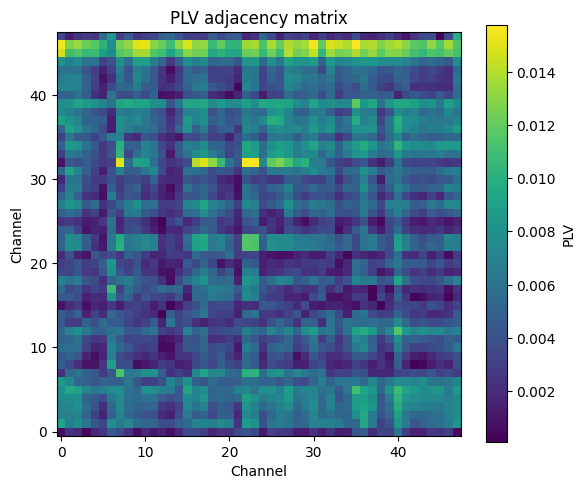

In [11]:
import matplotlib.pyplot as plt
import numpy as np

print("PLV min:", plv_matrix.min())
print("PLV max:", plv_matrix.max())

vmin = plv_matrix.min()
vmax = plv_matrix.max()

plt.figure(figsize=(6, 5))
im = plt.imshow(plv_matrix,
                origin='lower',
                aspect='equal',
                vmin=vmin,
                vmax=vmax)
plt.colorbar(im, label='PLV')
plt.title('PLV adjacency matrix')
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.tight_layout()
plt.show()

In [14]:
# Glossary of channel names to indices

# Get all channel names
channels = raw.ch_names

# Find their indices
i_ahl5 = channels.index('mAHL5')
i_ecl1 = channels.index('mECL1')

print(f"mAHL5 index: {i_ahl5}")
print(f"mECL1 index: {i_ecl1}")

# index to channel name dictionary
index_to_name = {idx: name for idx, name in enumerate(raw.ch_names)}

# print a few examples
print(index_to_name[47])
print(index_to_name[1])

mAHL5 index: 4
mECL1 index: 16
mPHR8
mAHL2
